In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

# digit

In [48]:
path = "./digit-recognizer/train.csv"

In [49]:
data = pd.read_csv(path)

In [50]:
data.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [51]:
target = data.label
data.drop("label", axis=1, inplace=True)
data = data.to_numpy(copy=True)

## Image Shape is 28*28 

In [52]:
n_data = data.shape[0]
W = data.shape[1]
H = data.shape[1]

In [64]:
data = data.reshape(n_data, 28, 28)

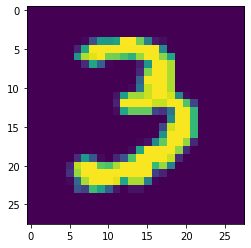

In [65]:
plt.imshow(data[9]);

# DCAE

## torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
## torch.nn.MaxPool1d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

## torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')

In [436]:
class DCAE(nn.Module):
    
    def __init__(self):
        super(DCAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, padding=1),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, padding=1),
            nn.Conv1d(in_channels=32, out_channels=12, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=12, out_channels=12, kernel_size=5),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=12, out_channels=12, kernel_size=3, stride=2, output_padding=1),
            nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=32, kernel_size=2, stride=2, output_padding=1),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=10),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=3, kernel_size=10)
        )
        
        self.conv = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=10, stride=1, padding=6)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, padding=1)
        self.trans = nn.ConvTranspose1d(in_channels=12, out_channels=12, kernel_size=3, output_padding=1)
        
    def demo(self, x):
        x = self.conv(x)
        #x = self.relu(x)
        #x = self.maxpool(x)
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = x.view(x.size(0), 12, 5)
        x = self.decoder(x)
        
        return x

In [437]:
net = DCAE()

In [438]:
net

DCAE(
  (encoder): Sequential(
    (0): Conv1d(3, 64, kernel_size=(10,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 12, kernel_size=(5,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv1d(12, 12, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(12, 12, kernel_size=(3,), stride=(2,), output_padding=(1,))
    (3): Conv1d(12, 32, kernel_size=(5,), stride=(1,))
    (4): ReLU()
    (5): ConvTranspose1d(32, 32, kernel_size=(2,), stride=(2,), output_padding=(1,))
    (6): Conv1d(32, 64, kernel_size=(10,), stride=(1,))
    (7): ReLU()
    (8): Conv1d(64, 3, kernel_size=(10,), stride=(1,))
  )
  (conv): Conv1d(3, 64, kernel_s

In [439]:
model = DCAE()
in_data = torch.randn(100, 3, 60)
out_data = model.demo(in_data)
print(out_data.size()) #torch.Size([8, 2])

torch.Size([100, 64, 63])


In [440]:
def cc(l, pad, dil, ks, stride):
    return (l+2*pad-dil*(ks-1)-1)/stride + 1

In [441]:
cc(60, 3, 1, 8, 1)

59.0